In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
chunk_size = 10000

In [4]:
# Load v1 & v2 train data

df_train_v1 = pd.read_csv('train.csv')
df_train_v2 = pd.read_csv('train_v2.csv')
df_train = pd.concat([df_train_v1, df_train_v2], ignore_index=True).reset_index(drop=True)
df_train.drop_duplicates('msno',keep='last',inplace=True)

In [5]:
# load test data

df_test = pd.read_csv('sample_submission_v2.csv')

In [6]:
# Load members with msno only in the train data

df_members = pd.read_csv('members_v3.csv')

In [7]:
chunks_trans = pd.read_csv('transactions.csv', iterator=True, chunksize=chunk_size)

df_trans = pd.concat(list(chunks_trans), ignore_index=True)

In [8]:
df_trans = pd.concat([df_trans, pd.read_csv('transactions_v2.csv')], ignore_index=True)

In [11]:
df_logs = pd.DataFrame()

chunks_logs = pd.read_csv('user_logs_v2.csv', iterator=True, chunksize=chunk_size)

for chunk in chunks_logs:
    chunk['num_25'] = chunk['num_25'].astype(np.int16)
    chunk['num_50'] = chunk['num_50'].astype(np.int16)
    chunk['num_75'] = chunk['num_75'].astype(np.int16)
    chunk['num_985'] = chunk['num_985'].astype(np.int16)
    chunk['num_100'] = chunk['num_100'].astype(np.int16)
    chunk['total_secs'] = chunk['total_secs'].astype(np.float32)
    chunk['date'] = chunk['date'].astype(np.int32)
    
    df_logs = pd.concat([df_logs,chunk], ignore_index=True)

In [12]:
#f,ax=plt.subplots(1,2,figsize=(16,8))
#sns.stripplot(x="is_churn", y="city", data=df_members_train, ax=ax[0])
#sns.countplot(x='city', data=df_members_train, ax=ax[1])

In [13]:
#f,ax=plt.subplots(1,2,figsize=(16,8))
#sns.stripplot(x="is_churn", y="registered_via", data=df_members_train, ax=ax[0])
#sns.countplot(x='registered_via', data=df_members_train, ax=ax[1])

# Features engineering for members.csv

In [14]:
# convert date to datetime

df_members['registration_init_dtime'] = pd.to_datetime(df_members['registration_init_time'],format='%Y%m%d')

In [15]:
# get #of days from April 1st to members registration time

from datetime import date

df_members['subscription_days'] = (date(2017,4,1) - df_members['registration_init_dtime']).dt.days

In [16]:
# drop useless columns before merging with transactions

df_members.drop(['gender','bd','registration_init_time','registration_init_dtime','city','registered_via'],axis=1,inplace=True)

In [17]:
#sns.countplot(x='is_churn',data=df_members_train)

In [18]:
#f,ax=plt.subplots(1,2,figsize=(16,8))
#sns.distplot(df_members_train['subscription_days'], bins=20, ax=ax[0])
#sns.countplot(x='subscription_days',data=df_members_train,hue='is_churn', palette='YlGnBu')

In [19]:
#sns.pairplot(df_members_train[['city','registered_via','is_churn','subscription_days']], hue='is_churn')

In [20]:
df_members_train = pd.merge(df_members, df_train, on='msno', how='inner')
df_members_test = pd.merge(df_members, df_test, on='msno', how='right')

# Features engineering for transactions.csv

In [21]:
# merge df_trans and df_members_trains so only has to process msnos that are in train.csv

df_merge = pd.merge(df_trans, pd.concat([df_members_train,df_members_test],ignore_index=True), on='msno', how='right')

In [22]:
# remove unnecessary dfs to save memory

del df_members
del df_train_v1
del df_train_v2
del df_members_train
del df_members_test
del df_trans

In [23]:
def df_lower_mem(df):
    df['payment_method_id'] = df['payment_method_id'].astype(np.int8)
    df['payment_plan_days'] = df['payment_plan_days'].astype(np.int16)
    df['plan_list_price'] = df['plan_list_price'].astype(np.int16)
    df['actual_amount_paid'] = df['actual_amount_paid'].astype(np.int16)
    df['is_auto_renew'] = df['is_auto_renew'].astype(np.int8)
    df['is_cancel'] = df['is_cancel'].astype(np.int8)
    df['is_churn'] = df['is_churn'].astype(np.int8)
    return df

df_merge = df_lower_mem(df_merge)

In [24]:
# drop rows that have no payments

#df_merge = df_merge.drop(df_merge[df_merge['actual_amount_paid'] <= 0].index)

In [25]:
# Re-calculate payment_plan_days if 0

#df_merge['payment_plan_days'] = np.where(df_merge['payment_plan_days']==0,(df_merge['membership_expire_dtime']-df_merge['transaction_dtime']).dt.days,df_merge['payment_plan_days'])

#df_merge.loc[df_merge['payment_plan_days']==0,'payment_plan_days'] = (df_merge['membership_expire_dtime']-df_merge['transaction_dtime']).dt.days

In [26]:
#Set payment_plan_days back to 0 if re-calculation is -ive


#df_merge.loc[df_merge['payment_plan_days']<0,'payment_plan_days'] = 0

In [27]:
#a If plan_list_price is 0 assume it is actual_amount_paid

#df_merge.loc[df_merge['plan_list_price']<=0,'plan_list_price'] = df_merge['actual_amount_paid']

In [28]:
groupby_msno = df_merge.groupby(df_merge['msno'])

In [29]:
# Count # of transactions

df_merge['trans_count'] = (groupby_msno['payment_method_id'].transform('count')).astype(np.int16)

In [30]:
# Total subscription days

df_merge['total_pay_days'] = (groupby_msno['payment_plan_days'].transform('sum')).astype(np.int16)

In [31]:
# Average payment in each transaction

df_merge['avg_pay'] = (groupby_msno['actual_amount_paid'].transform('mean')).astype(np.int16)

In [32]:
# Total subscription payment

df_merge['total_payments'] = (groupby_msno['actual_amount_paid'].transform('sum')).astype(np.int16)

In [33]:
# Assume is_cancel = 1 with actual payment > 0 is a plan change; count the total number of plan changes

#df_merge['count_plan_change'] = groupby_msno['is_cancel'].transform(lambda x: (x==1).sum())

In [34]:
# Count # of auto_renew

#df_merge['count_auto_renew'] = groupby_msno['is_auto_renew'].transform(lambda x: (x==1).sum())

In [35]:
# Average list Price

df_merge['avg_list_price'] = (groupby_msno['plan_list_price'].transform('mean')).astype(np.int16)

In [36]:
# Keep only the record with the most recent transaction date 

df_merge = df_merge.sort_values(by=['transaction_date'], ascending=False).reset_index(drop=True)
df_merge.drop_duplicates('msno',keep='first',inplace=True)

In [37]:
df_merge['transaction_days'] = pd.to_datetime(df_merge['transaction_date'],format='%Y%m%d')
df_merge['membership_expire_days'] = pd.to_datetime(df_merge['membership_expire_date'],format='%Y%m%d')

In [38]:
# Calculate last transaction is how many days ago from April

df_merge['last_trans_days'] = ((date(2017,4,1) - df_merge['transaction_days']).dt.days).astype(np.int16)

In [39]:
df_merge['membership_expiry_days_fr_April'] = ((date(2017,4,1) - df_merge['membership_expire_days']).dt.days).astype(np.int16)

In [40]:
df_merge.drop(['transaction_date','membership_expire_date','transaction_days','membership_expire_days'],axis=1,inplace=True)

In [41]:
df_merge_train = pd.merge(df_merge.drop('is_churn',axis=1), df_train, on='msno', how='inner')
df_merge_test = pd.merge(df_merge.drop('is_churn',axis=1), df_test, on='msno', how='right')

In [42]:
df_merge_test.drop('is_churn',inplace=True,axis=1)

# Features engineering for user_log.csv

In [43]:
# merge df_trans and df_members_trains so only has to process msnos that are in user_logs.csv

df_merge_logs = pd.merge(df_logs, pd.concat([df_train,df_test],ignore_index=True), on='msno', how='right')

In [44]:
df_merge_logs.fillna(value=0, inplace=True)

In [45]:
def df_logs_lower_mem(df):
    df['num_25'] = df['num_25'].astype(np.int16)
    df['num_50'] = df['num_50'].astype(np.int16)
    df['num_75'] = df['num_75'].astype(np.int16)
    df['num_985'] = df['num_985'].astype(np.int16)
    df['num_100'] = df['num_100'].astype(np.int16)
    df['total_secs'] = df['total_secs'].astype(np.float32)
    df['date'] = df['date'].astype(np.int32)
    df['num_unq'] = df['num_unq'].astype(np.int16)
    df.drop('is_churn',axis=1,inplace=True)
    return df

df_merge_logs = df_logs_lower_mem(df_merge_logs)

del df_logs

In [46]:
df_merge_logs.drop_duplicates(['msno','date'],inplace=True)

In [47]:
logs_groupby_msno = df_merge_logs.groupby(df_merge_logs['msno'])

In [48]:
# Count # of play days

df_merge_logs['play_days'] = (logs_groupby_msno['date'].transform('count')).astype(np.int8)

In [49]:
df_merge_logs.loc[df_merge_logs['date']==0,'play_days'] = 255

In [50]:
# Count # of play days

#df_merge_logs['avg_25'] = (logs_groupby_msno['num_25'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_50'] = (logs_groupby_msno['num_50'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_75'] = (logs_groupby_msno['num_75'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_985'] = (logs_groupby_msno['num_985'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_100'] = (logs_groupby_msno['num_100'].transform('mean')).astype(np.int16)
#df_merge_logs['avg_unq'] = (logs_groupby_msno['num_unq'].transform('mean')).astype(np.int16)

In [51]:
df_merge_logs['total_month_secs'] = (logs_groupby_msno['total_secs'].transform('sum')).astype(np.float32)

In [52]:
# Keep only the record with the most recent transaction date 

df_merge_logs = df_merge_logs.sort_values(by=['date'], ascending=False).reset_index(drop=True)
df_merge_logs.drop_duplicates('msno',keep='first',inplace=True)

In [53]:
df_merge_logs.loc[df_merge_logs['date']!=0,'dtime'] = pd.to_datetime(df_merge_logs[df_merge_logs['date']!=0]['date'],format='%Y%m%d')

In [54]:
df_merge_logs.loc[df_merge_logs['date']!=0,'last_play_days'] = ((date(2017,4,1) - df_merge_logs[df_merge_logs['date']!=0]['dtime']).dt.days).astype(np.int8)

In [55]:
df_merge_logs.drop(['date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100','num_unq', 'total_secs','dtime'],axis=1,inplace=True)

In [56]:
df_merge_train = pd.merge(df_merge_train, df_merge_logs, on='msno', how='inner')
df_merge_test = pd.merge(df_merge_test, df_merge_logs, on='msno', how='left')

# Training the models

In [57]:
from sklearn.model_selection import train_test_split

In [59]:
features = ['payment_method_id',
            'plan_list_price',
            'subscription_days',
            'trans_count',
            'total_pay_days',
            'avg_pay',
            'total_payments',
            'avg_list_price',
            'last_trans_days',
            'membership_expiry_days_fr_April',
            'play_days',
            'total_month_secs', 
            'last_play_days']

X = df_merge_train[features]
y = df_merge_train['is_churn']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

# Train with XGBoost

In [74]:
import xgboost as xgbt

In [75]:
d_train = xgbt.DMatrix(X_train, label=y_train)
d_test = xgbt.DMatrix(X_test, label=y_test)

In [87]:
params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 5,
    'eta':.1,
    'subsample': 1,
    'colsample_bytree': 0.8,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric': "logloss"
}

In [88]:
model = xgbt.train(
    params,
    d_train,
    num_boost_round=999,
    evals=[(d_test,'is_churn')],
    early_stopping_rounds=10
)

[0]	is_churn-logloss:0.60831
Will train until is_churn-logloss hasn't improved in 10 rounds.
[1]	is_churn-logloss:0.53763
[2]	is_churn-logloss:0.481994
[3]	is_churn-logloss:0.434935
[4]	is_churn-logloss:0.391811
[5]	is_churn-logloss:0.3574
[6]	is_churn-logloss:0.32713
[7]	is_churn-logloss:0.297765
[8]	is_churn-logloss:0.272225
[9]	is_churn-logloss:0.252091
[10]	is_churn-logloss:0.232192
[11]	is_churn-logloss:0.214694
[12]	is_churn-logloss:0.199284
[13]	is_churn-logloss:0.185662
[14]	is_churn-logloss:0.173798
[15]	is_churn-logloss:0.163014
[16]	is_churn-logloss:0.153522
[17]	is_churn-logloss:0.145938
[18]	is_churn-logloss:0.138459
[19]	is_churn-logloss:0.131692
[20]	is_churn-logloss:0.125559
[21]	is_churn-logloss:0.120229
[22]	is_churn-logloss:0.115177
[23]	is_churn-logloss:0.111216
[24]	is_churn-logloss:0.107155
[25]	is_churn-logloss:0.103729
[26]	is_churn-logloss:0.100912
[27]	is_churn-logloss:0.097889
[28]	is_churn-logloss:0.095167
[29]	is_churn-logloss:0.09325
[30]	is_churn-logloss:

# Prediction and Evaluations

In [90]:
d_sub = xgbt.DMatrix(df_merge_test[features])

In [97]:
pred_sub = model.predict(d_sub)

In [93]:
from sklearn.metrics import classification_report,confusion_matrix,log_loss

In [94]:
pred

array([  6.97480136e-05,   8.02756404e-05,   1.78939561e-04, ...,
         9.72325265e-01,   9.49071884e-01,   9.58846450e-01], dtype=float32)

In [66]:
print(confusion_matrix(y_test,predictions))

[[280759   2641]
 [  5938  31463]]


In [67]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.98      0.99      0.98    283400
          1       0.92      0.84      0.88     37401

avg / total       0.97      0.97      0.97    320801



In [96]:
print(log_loss(y_test,pred))

0.0622392432394


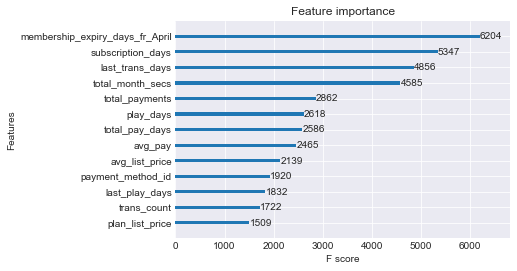

In [91]:
from xgboost import plot_importance

plot_importance(model)

# Prediction test file

In [98]:
df_merge_test['is_churn'] = pred_sub

In [100]:
df_merge_test[['msno','is_churn']].to_csv('submission.csv.gz', index=False, compression='gzip')

In [99]:
df_merge_test[['msno','is_churn']]

,msno,is_churn
0,qPSxhrsxPhhSySQ1FAPr8VkGod4grctf89zpvUJia1Y=,0.000070
1,DHGcKsvkK6r7jLCQ3yPoK4ST4I7VP77594CsbI3AMxk=,0.000080
2,gzl78fz7VVCXM5V55Zqt4nSoiAaitqKvATjJ/7E1bKg=,0.000179
3,VRf0Vd5HyHoowUi1ZCOGctFeMsuyqGOrLKQluMVl7mY=,0.000251
4,8gfoT8eIaujK15FQGIO5kCpcV1amFO6TVWppYUgrfhA=,0.000076
5,wLTMlDyVibwW6M7XqUBAIlbPUnElyIYQezA/UMURqCU=,0.002875
6,NwIdiZCXzzJtdOOMXjXUL8wSEw8Dh5JUB/s+SwT9TJc=,0.000640
7,P8KpROAxmCyO0Q0HS7TkI/2KfT5Dxhl6KzzAsZ/1yag=,0.000102
8,nLwadO1AYMdn377DAdRkkOxL2Sgk7MyhQW5knUJqtZc=,0.000129
9,Vphe6ihTbDu55i43niPPejzUXvlPquduAB6wdwmr6dE=,0.000073
